# Deep Learning
***

In this notebook we will approach the prediction problem using Neural Networks.

For theory on neural networks we refer to Andrew Ng's [lecture notes](https://cs229.stanford.edu/main_notes.pdf). Information on utilizing Keras effectively can be found in the book [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff).

In [65]:
import pandas as pd
import numpy as np
import sklearn as sk
import sklearn.model_selection as skm
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns

from extraFunctions import *

## Load the data
***
First we load the data, drop all unnecessary columns, and scale the data (see the featureEngineering notebook for details on preliminary preprocessing):

In [66]:
train = pd.read_csv('data/processedTrain.csv')
test  = pd.read_csv('data/processedTest.csv')

drop_cols = ['Deck', 'Embarked', 'Family', 'Family_Size', 'Family_Size_Grouped', 'Survived',
             'Name', 'Parch', 'PassengerId', 'Pclass', 'Sex', 'SibSp', 'Ticket', 'Title',
            'Ticket_Survival_Rate', 'Family_Survival_Rate', 'Ticket_Survival_Rate_NA', 'Family_Survival_Rate_NA']

y = train['Survived'].values
X = StandardScaler().fit_transform(train.drop(columns=drop_cols))
X_test  = StandardScaler().fit_transform(test.drop(columns=drop_cols))

X_train, X_cv, y_train, y_cv = skm.train_test_split(X, y, test_size=0.2, random_state=42)

We will use a NN architecture with two hidden layers.
Furthermore, we will use the binary cross-entropy loss function and use the accuracy metric:

In [67]:
def build_model():
    model = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
    ])

    model.compile(optimizer="rmsprop",
                loss="binary_crossentropy",
                metrics=["accuracy"])
    
    return model

We utilise k(=4)-fold cross validation to detect the optimal number of epochs:

In [68]:
k = 5 # number of folds
num_val_samples = len(X_train) // k
num_epochs = 200
all_accuracy_histories = []

for i in range(k):
    print(f"Processing fold #{i}")
    val_data = X_train[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = y_train[i * num_val_samples: (i + 1) * num_val_samples]

    partial_X_train = np.concatenate(
        [X_train[:i * num_val_samples],
         X_train[(i + 1) * num_val_samples:]],
        axis=0)
    partial_y_train = np.concatenate(
        [y_train[:i * num_val_samples],
         y_train[(i + 1) * num_val_samples:]],
        axis=0)
    
    # Build model using the partial train data
    model = build_model()
    # Fit the model
    history = model.fit(partial_X_train, partial_y_train,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=16, verbose=0)
    accuracy_history = history.history["accuracy"]
     # Save the history
    all_accuracy_histories.append(accuracy_history)

Processing fold #0


2023-11-20 19:52:33.995428: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-20 19:52:35.715709: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Processing fold #1


2023-11-20 19:54:55.853250: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-20 19:54:57.541379: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Processing fold #2


2023-11-20 19:57:18.143102: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-20 19:57:19.792062: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Processing fold #3


2023-11-20 19:59:41.108433: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-20 19:59:42.897423: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Processing fold #4


2023-11-20 20:02:01.474880: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-20 20:02:03.650158: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


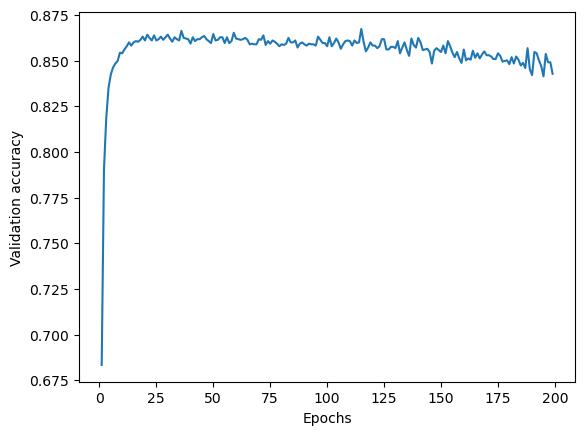

In [69]:
average_accuracy_history = [
    np.mean([x[i] for x in all_accuracy_histories]) for i in range(num_epochs)]

plt.plot(range(1, 200), average_accuracy_history[:199])
plt.xlabel("Epochs")
plt.ylabel("Validation accuracy")
plt.show()


We train the model with 25 epochs:

In [70]:
model = build_model()
model.fit(X_train, y_train, epochs=25, batch_size=16, verbose=0)

2023-11-20 20:04:22.453648: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


...and make a prediction on the validation set:

In [81]:
y_cv_hat = [ 1 if x > 0.55 else 0 for x in model.predict(X_cv) ]

6/6 [==============================] - 0s 6ms/step


And check out the confusion matrix:

The fraction of correct predictions is 0.86
The precision is 0.85
The recall is 0.81
The specificity is 0.87


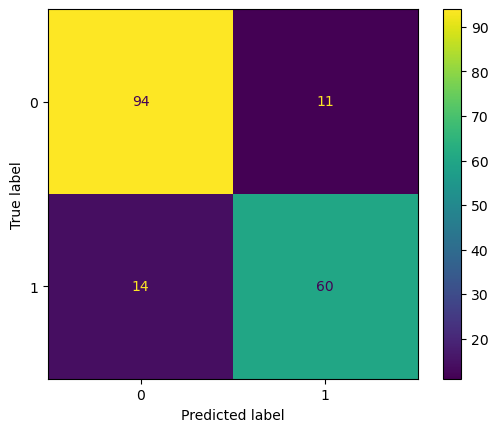

In [82]:
CM = sk.metrics.confusion_matrix( y_cv, y_cv_hat )
sk.metrics.ConfusionMatrixDisplay(CM).plot()
print("The fraction of correct predictions is {0:.2}".format((CM[0][0]+CM[1][1])/(CM[0][0]+CM[1][1]+CM[0][1]+CM[1][0])))
print("The precision is {0:.2}".format((CM[1][1])/(CM[1][1]+CM[0][1])))
print("The recall is {0:.2}".format((CM[1][1])/(CM[1][1]+CM[1][0])))
print("The specificity is {0:.2}".format(CM[0][0]/(CM[0][0]+CM[1][0])))

We save our approach:

In [76]:
model = build_model()
model.fit(X, y, epochs=25, batch_size=16, verbose=0)
predictions = [ 1 if x > 0.6 else 0 for x in model.predict(X_test) ]
string = 'submissionNN'
output = pandas.DataFrame({'PassengerId': test.PassengerId, 'Survived': predictions})
output.to_csv('submissions/{}.csv'.format(string), index=False)
print("Your submission was successfully saved!")

2023-11-20 20:05:54.997752: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 0s 4ms/step
Your submission was successfully saved!


2023-11-20 20:06:21.222033: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
